In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import re
from wordcloud import WordCloud
import json
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

output_dir = Path('data/processed/eda_results')
output_dir.mkdir(parents=True, exist_ok=True)


Data Loading

In [27]:

cleaned_dir = Path('data/processed/cleaned')

sec_sentences = []
news_sentences = []
earnings_sentences = []

sec_file = cleaned_dir / 'all_sec_sentences.txt'
if sec_file.exists():
    with open(sec_file, 'r', encoding='utf-8') as f:
        sec_sentences = [s.strip() for s in f.read().split('\n\n') if s.strip()]
    print(f"Loaded {len(sec_sentences):,} SEC sentences")
else:
    print(f"File not found: {sec_file}")

news_file = cleaned_dir / 'reuters_cleaned.txt'
if news_file.exists():
    with open(news_file, 'r', encoding='utf-8') as f:
        news_sentences = [s.strip() for s in f.read().split('\n\n') if s.strip()]
    print(f"Loaded {len(news_sentences):,} news sentences")
else:
    print(f"File not found: {news_file}")

earnings_file = cleaned_dir / 'all_earnings_sentences.txt'
if earnings_file.exists():
    with open(earnings_file, 'r', encoding='utf-8') as f:
        earnings_sentences = [s.strip() for s in f.read().split('\n\n') if s.strip()]
    print(f"Loaded {len(earnings_sentences):,} earnings call sentences")
else:
    print(f" File not found: {earnings_file}")

all_sentences = sec_sentences + news_sentences + earnings_sentences


print(f"Total sentences: {len(all_sentences):,}")


Loaded 19,302 SEC sentences
Loaded 10,468 news sentences
Loaded 2,436 earnings call sentences
Total sentences: 32,206


Basic Statistics

In [28]:

stats = {}

for name, sentences in [('SEC', sec_sentences),('News', news_sentences),('Earnings', earnings_sentences),('All', all_sentences)]:
    if not sentences:
        continue
    
    lengths = [len(s) for s in sentences]
    word_counts = [len(s.split()) for s in sentences]
    
    stats[name] = {
        'Count': len(sentences),
        'Avg Length (chars)': round(np.mean(lengths), 1),
        'Median Length': round(np.median(lengths), 1),
        'Min Length': np.min(lengths),
        'Max Length': np.max(lengths),
        'Avg Words': round(np.mean(word_counts), 1),
        'Total Words': sum(word_counts)
    }

stats_df = pd.DataFrame(stats).T
display(stats_df)

stats_df.to_csv(output_dir / 'basic_statistics.csv')


,Count,Avg Length (chars),Median Length,Min Length,Max Length,Avg Words,Total Words
SEC,19302.0,192.4,178.0,1.0,499.0,29.7,572574.0
News,10468.0,65.7,65.0,22.0,115.0,10.4,109095.0
Earnings,2436.0,134.3,123.0,31.0,490.0,21.8,53083.0
All,32206.0,146.8,108.0,1.0,499.0,22.8,734752.0


Sentence Length Distribution

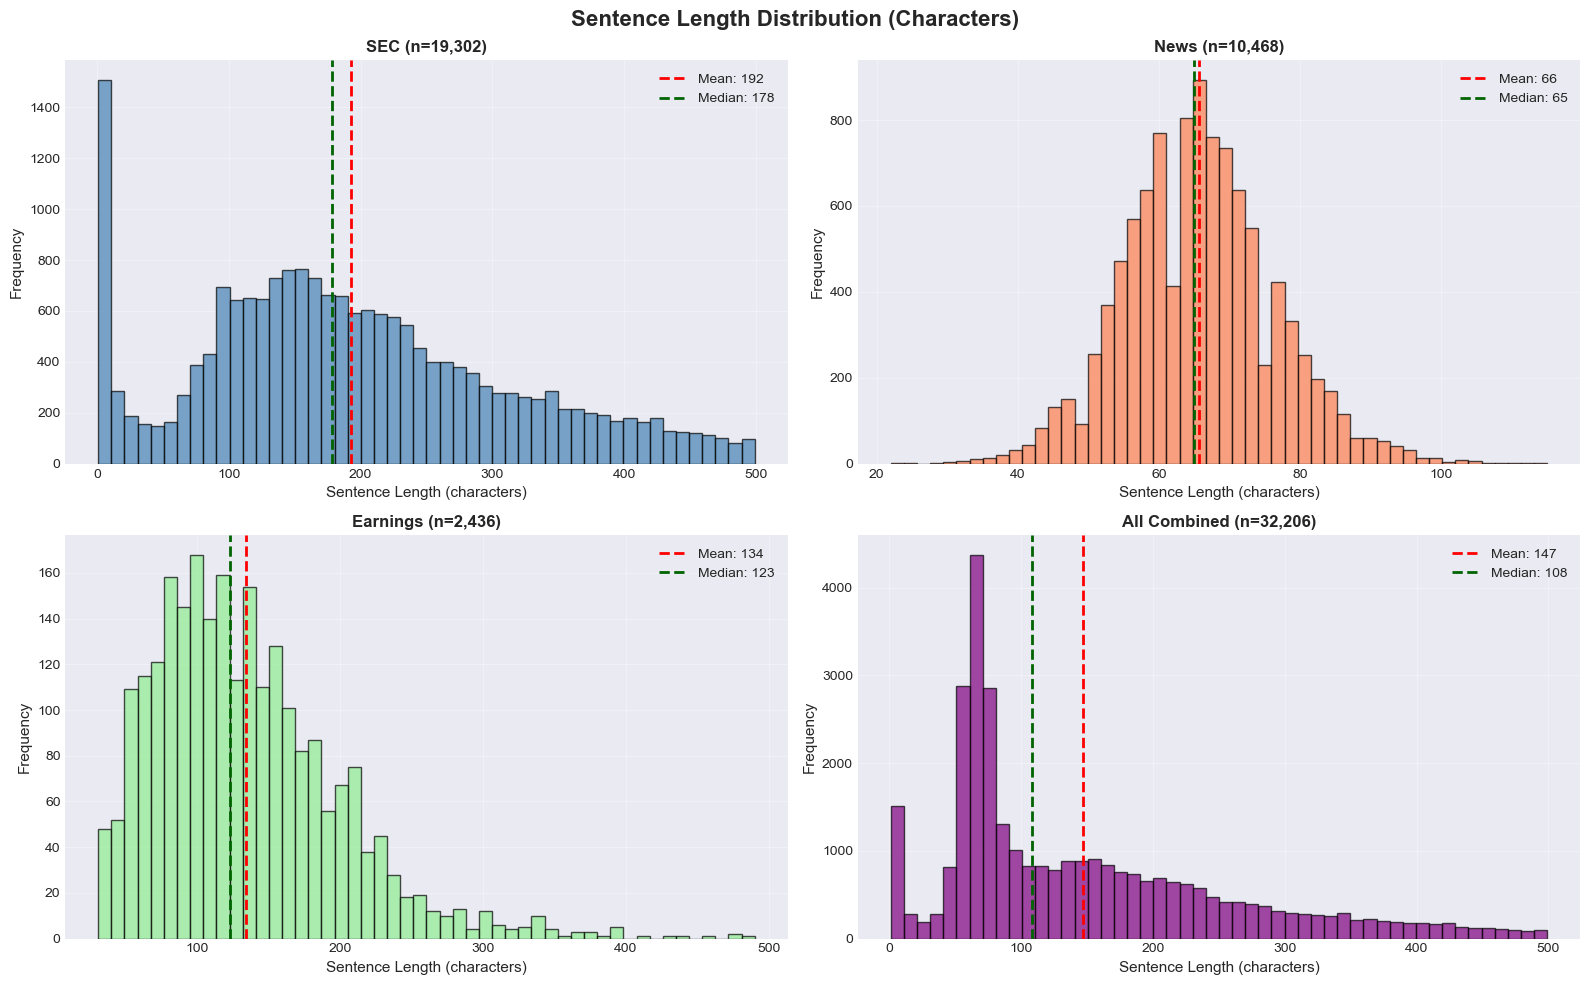

In [29]:

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Sentence Length Distribution (Characters)', fontsize=16, fontweight='bold')

datasets = [('SEC', sec_sentences, 'steelblue'),('News', news_sentences, 'coral'),('Earnings', earnings_sentences, 'lightgreen'),('All Combined', all_sentences, 'purple')]

for idx, (name, sentences, color) in enumerate(datasets):
    if not sentences:
        continue
    
    ax = axes[idx // 2, idx % 2]
    
    char_lengths = [len(s) for s in sentences]
    
    ax.hist(char_lengths, bins=50, edgecolor='black', alpha=0.7, color=color)
    ax.axvline(np.mean(char_lengths), color='red', linestyle='--', linewidth=2,
              label=f'Mean: {np.mean(char_lengths):.0f}')
    ax.axvline(np.median(char_lengths), color='darkgreen', linestyle='--', linewidth=2,
              label=f'Median: {np.median(char_lengths):.0f}')
    
    ax.set_xlabel('Sentence Length (characters)', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{name} (n={len(sentences):,})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Word Count Distribution

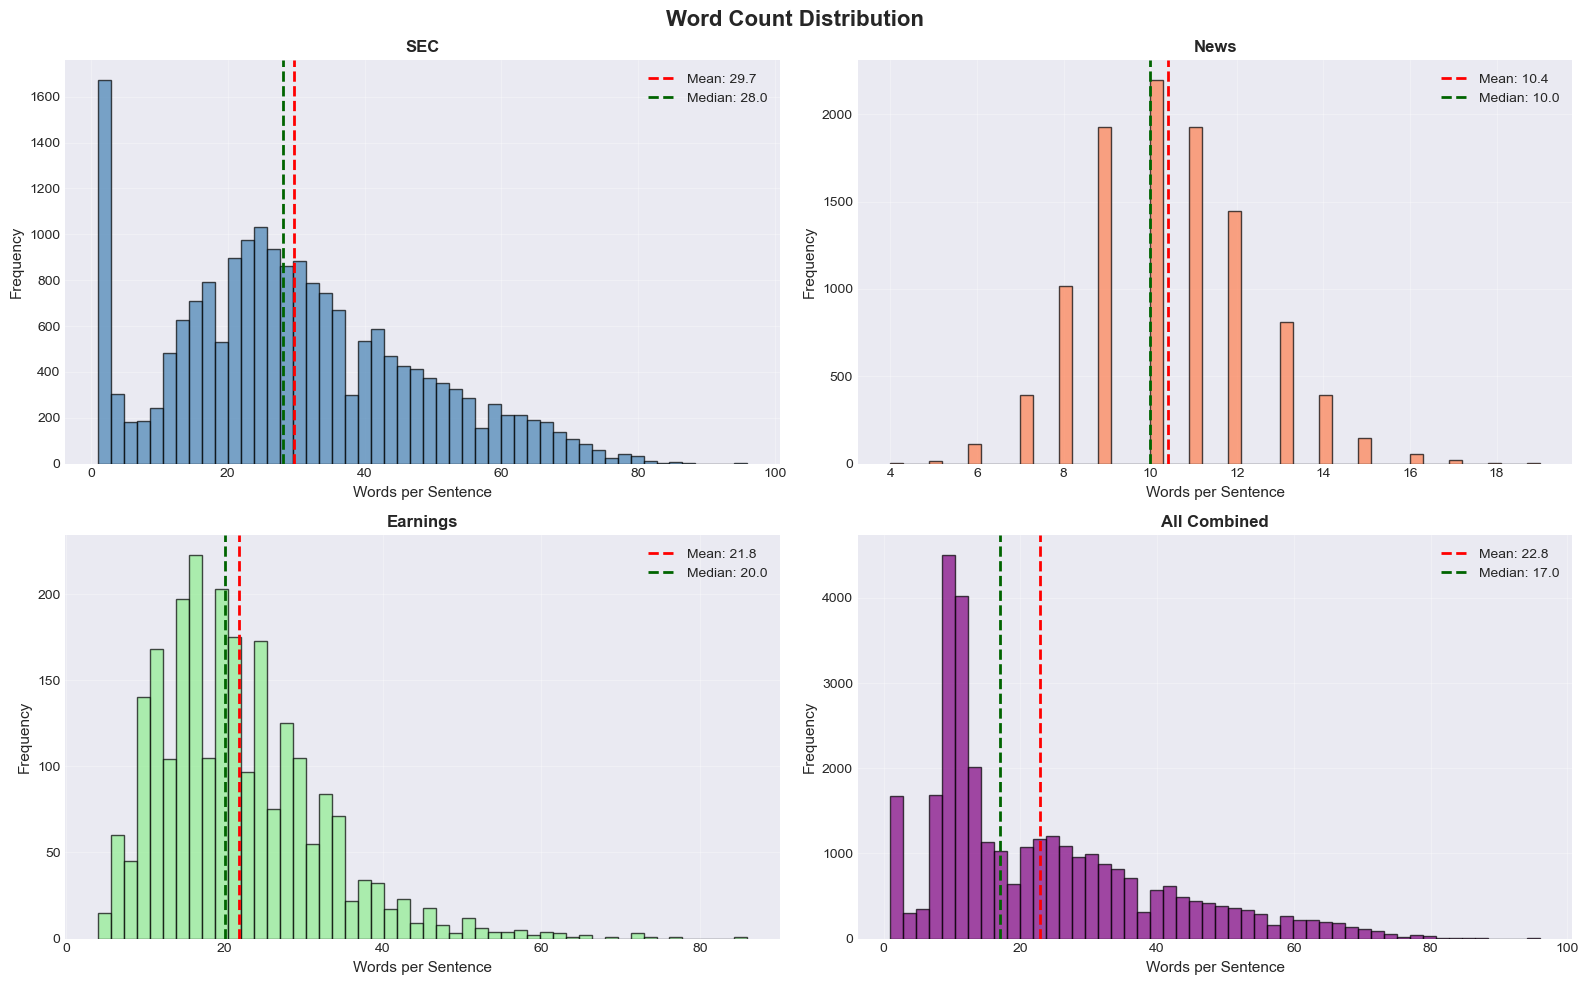

In [30]:

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Word Count Distribution', fontsize=16, fontweight='bold')

for idx, (name, sentences, color) in enumerate(datasets):
    if not sentences:
        continue
    
    ax = axes[idx // 2, idx % 2]
    
    word_counts = [len(s.split()) for s in sentences]
    
    ax.hist(word_counts, bins=50, edgecolor='black', alpha=0.7, color=color)
    ax.axvline(np.mean(word_counts), color='red', linestyle='--', linewidth=2,
              label=f'Mean: {np.mean(word_counts):.1f}')
    ax.axvline(np.median(word_counts), color='darkgreen', linestyle='--', linewidth=2,
              label=f'Median: {np.median(word_counts):.1f}')
    
    ax.set_xlabel('Words per Sentence', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'word_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Financial Keywords Analysis

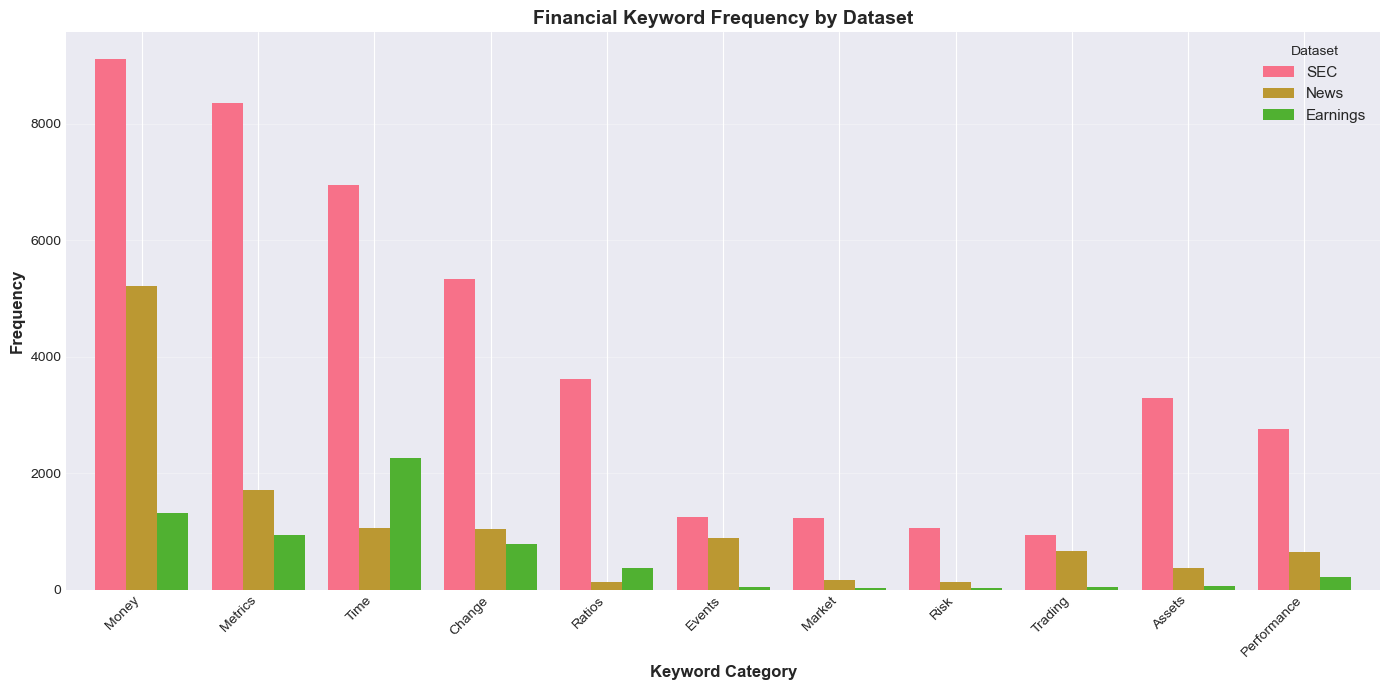

,SEC,News,Earnings
Money,9119,5212,1323
Metrics,8365,1705,936
Time,6951,1063,2267
Change,5343,1046,789
Ratios,3621,124,379
Events,1239,890,47
Market,1223,167,26
Risk,1055,123,33
Trading,943,666,53
Assets,3288,376,68


In [31]:
keywords = {
    'Money': ['billion', 'million', 'trillion', '$', '€', '£'],
    'Metrics': ['revenue', 'income', 'earnings', 'profit', 'loss', 'ebitda', 'eps'],
    'Time': ['quarter', 'fiscal', 'year', 'q1', 'q2', 'q3', 'q4'],
    'Change': ['growth', 'increase', 'decrease', 'rise', 'fall', 'decline'],
    'Ratios': ['p/e', 'ratio', 'margin', 'roe', 'roi'],
    'Events': ['merger', 'acquisition', 'ipo', 'split', 'dividend'],
    'Market': ['bull', 'bear', 'volatility', 'index', 'sector', 'exchange'],
    'Risk': ['risk', 'exposure', 'leverage', 'beta', 'volatility'],
    'Trading': ['trade', 'volume', 'liquidity', 'bid', 'ask', 'spread'],
    'Assets': ['assets', 'liabilities', 'equity', 'capital', 'debt'],
    'Performance': ['return', 'yield', 'performance', 'gain', 'loss']
}

results = {}

for category, words in keywords.items():
    results[category] = {}
    
    for name, sentences in [('SEC', sec_sentences), ('News', news_sentences), ('Earnings', earnings_sentences)]:
        if not sentences:
            continue
        
        text = ' '.join(sentences).lower()
        count = sum(text.count(word) for word in words)
        results[category][name] = count

df_keywords = pd.DataFrame(results).T

fig, ax = plt.subplots(figsize=(14, 7))
df_keywords.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Keyword Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Financial Keyword Frequency by Dataset', fontsize=14, fontweight='bold')
ax.legend(title='Dataset', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(output_dir / 'keyword_frequency.png', dpi=300, bbox_inches='tight')
plt.show()

display(df_keywords)

df_keywords.to_csv(output_dir / 'keyword_frequency.csv')


Most  Common Words

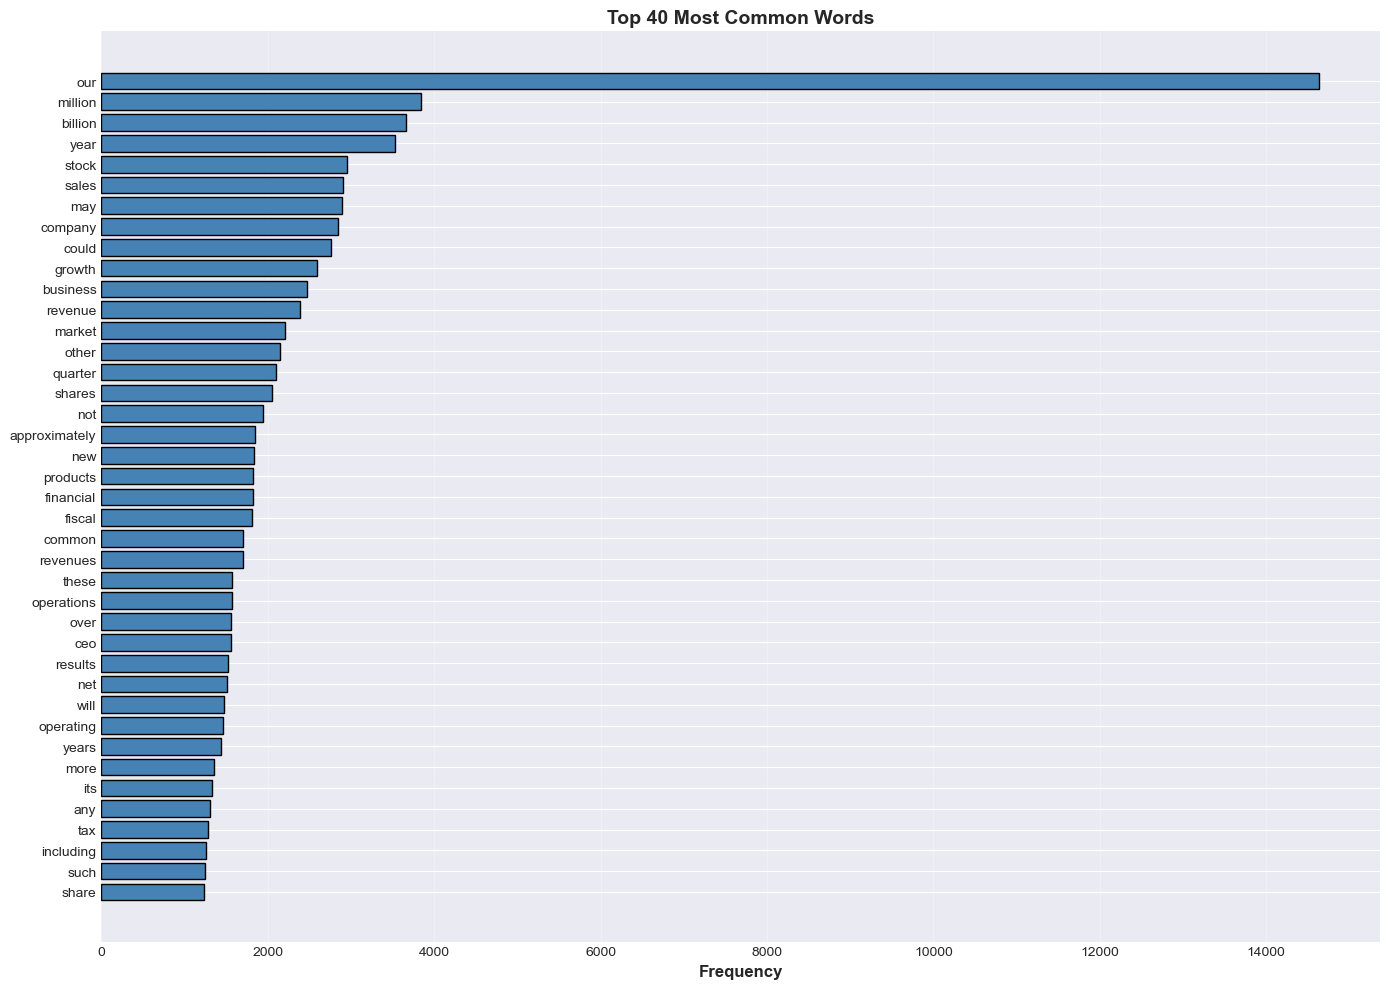

In [32]:
all_text = ' '.join(all_sentences).lower()
words = re.findall(r'\b[a-z]{3,}\b', all_text)

stopwords = {'the', 'and', 'for', 'that', 'with', 'from', 'this', 'are', 
             'was', 'were', 'been', 'have', 'has', 'had', 'which', 'their'}
words = [w for w in words if w not in stopwords]

word_freq = Counter(words)
top_words = word_freq.most_common(40)

words_list, counts = zip(*top_words)

fig, ax = plt.subplots(figsize=(14, 10))
ax.barh(range(len(words_list)), counts, color='steelblue', edgecolor='black')
ax.set_yticks(range(len(words_list)))
ax.set_yticklabels(words_list, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Top 40 Most Common Words', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(output_dir / 'top_words.png', dpi=300, bbox_inches='tight')
plt.show()

pd.DataFrame(top_words, columns=['Word', 'Frequency']).to_csv(
    output_dir / 'top_words.csv', index=False
)


Word CLouds

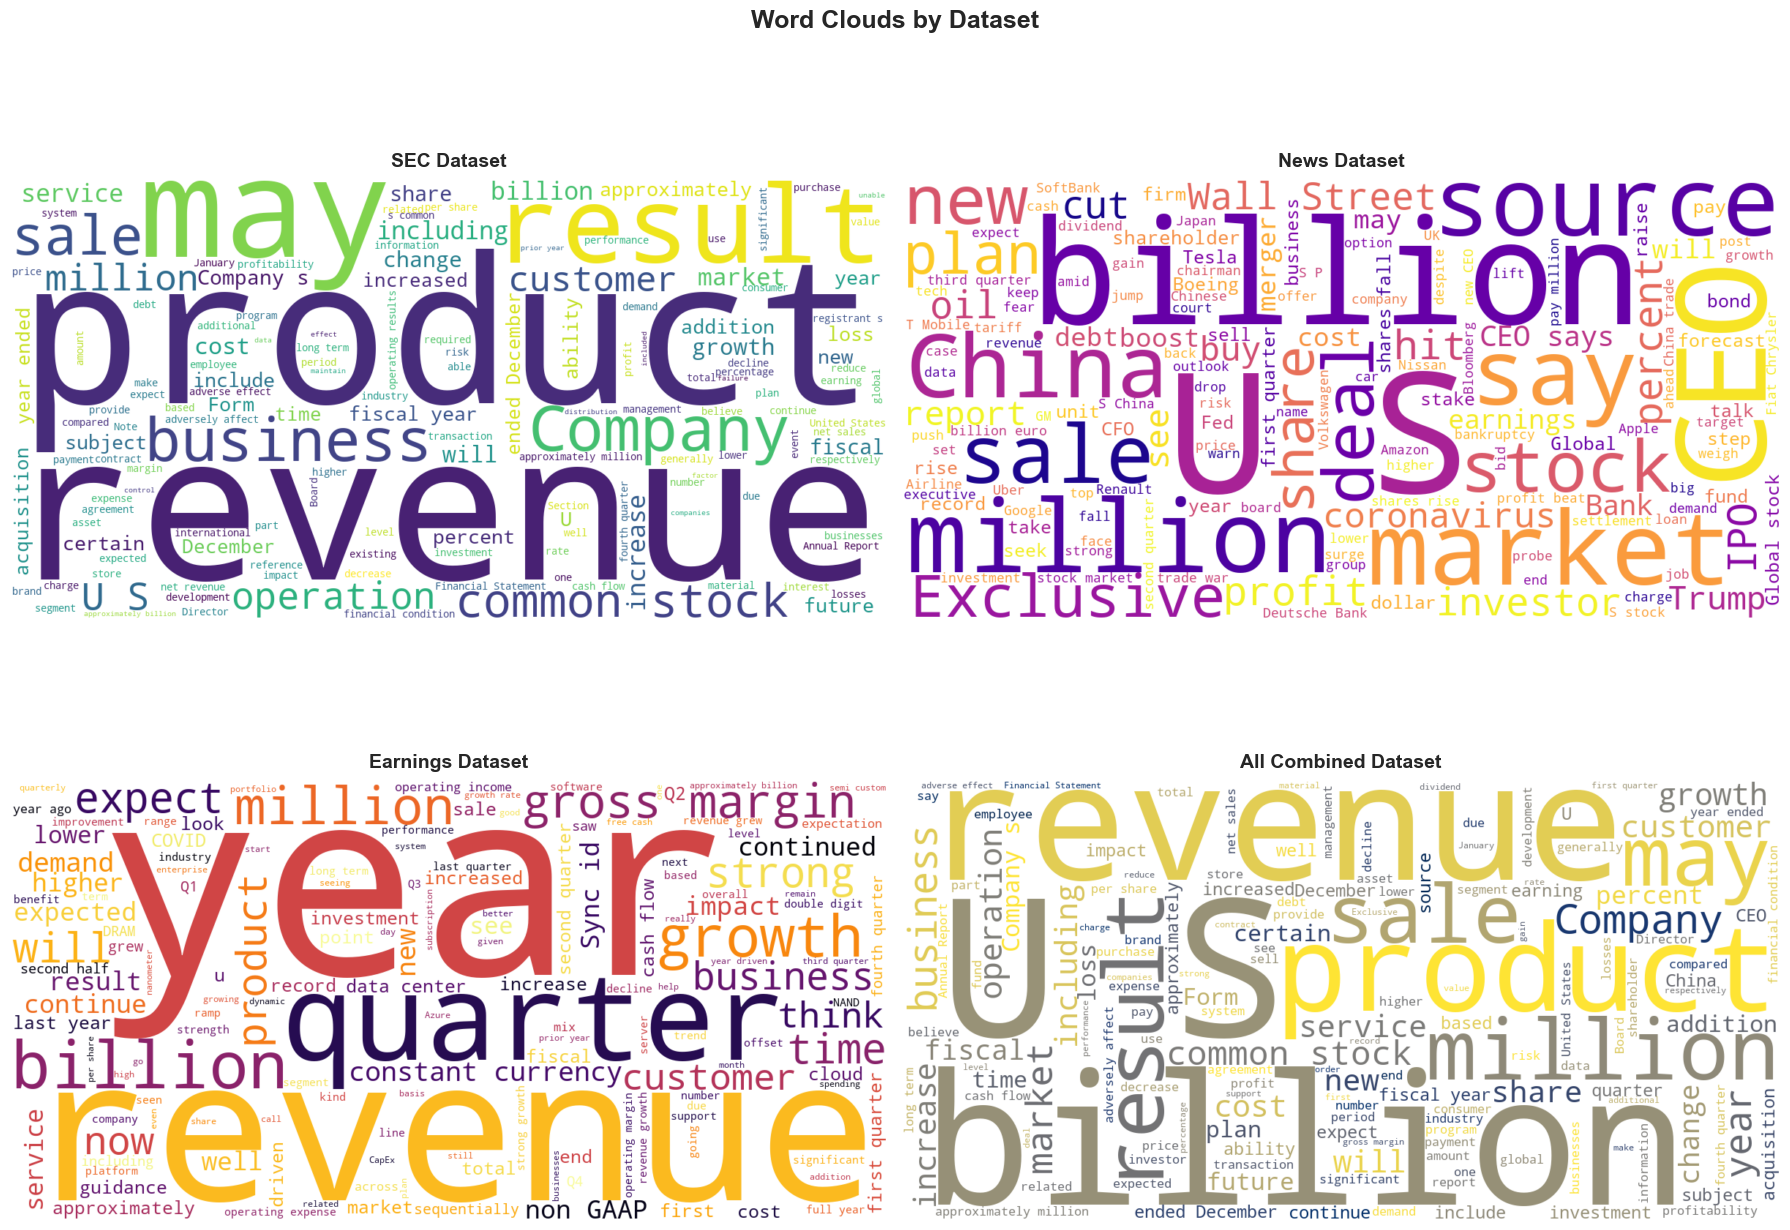

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Word Clouds by Dataset', fontsize=18, fontweight='bold')

datasets_wc = [
    ('SEC', sec_sentences, 'viridis'),
    ('News', news_sentences, 'plasma'),
    ('Earnings', earnings_sentences, 'inferno'),
    ('All Combined', all_sentences, 'cividis')
]

for idx, (name, sentences, colormap) in enumerate(datasets_wc):
    if not sentences:
        continue
    
    ax = axes[idx // 2, idx % 2]
    
    text = ' '.join(sentences)
    
    wordcloud = WordCloud(
        width=1200, 
        height=600,
        background_color='white',
        colormap=colormap,
        max_words=150,
        relative_scaling=0.5,
        min_font_size=10
    ).generate(text)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'{name} Dataset', fontsize=14, fontweight='bold', pad=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig(output_dir / 'wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()


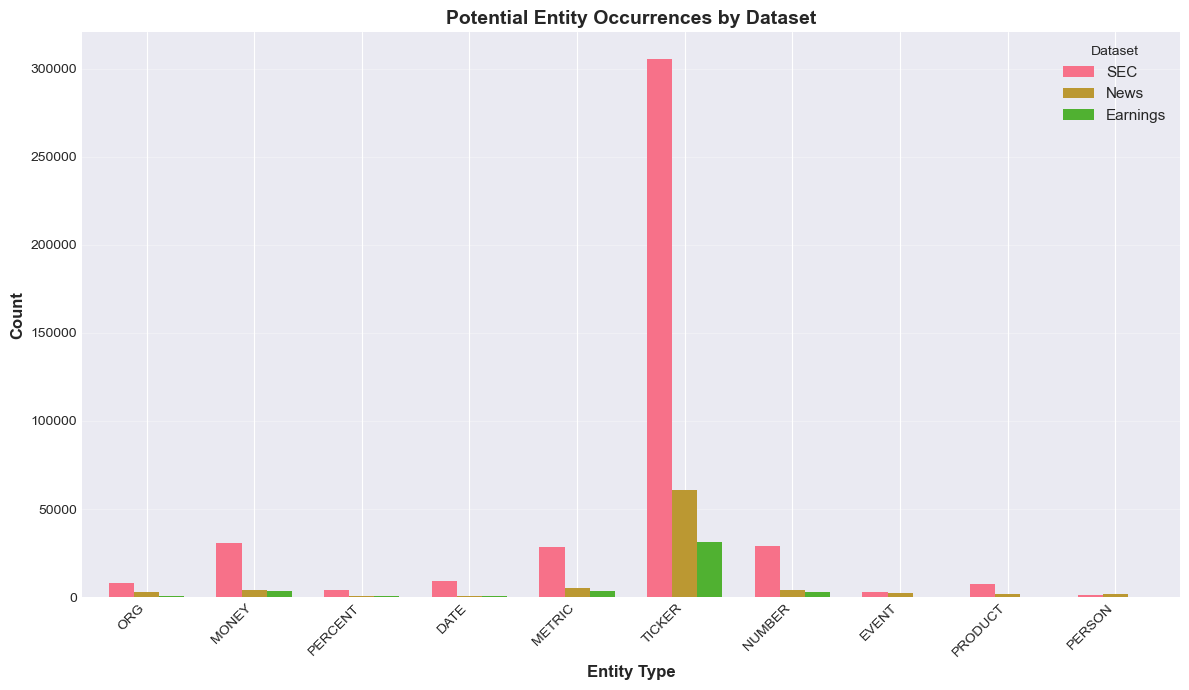

,SEC,News,Earnings
ORG,7835,2891,490
MONEY,30558,4345,3277
PERCENT,4197,542,913
DATE,9389,586,549
METRIC,28765,5230,3297
TICKER,305308,60992,31536
NUMBER,29084,4220,2813
EVENT,2984,2281,145
PRODUCT,7367,1896,329
PERSON,1074,1674,94


In [34]:
patterns = {
    'ORG': r'''(?x)
        \b[A-Z][a-zA-Z]+(?:\s+[A-Z&][a-zA-Z&]*)*\s+(?:Inc\.?|Corp\.?|Corporation|LLC|Ltd\.?|Limited|Co\.?|Company|LP|LLP|PLC|Group|Holdings?|Partners?|Trust|Bank|Capital|Ventures?|Technologies|Systems|Solutions|Services|International|Global)\b
        |
        \b(?:Apple|Google|Microsoft|Amazon|Meta|Tesla|Netflix|Nvidia|Intel|AMD|Oracle|Salesforce|Adobe|PayPal|Uber|Lyft|Airbnb|SpaceX|Twitter|Facebook|Instagram|WhatsApp|LinkedIn|YouTube|Walmart|Target|Costco|McDonald's|Starbucks|Nike|Adidas|Coca-Cola|PepsiCo|Johnson\s+&\s+Johnson|Pfizer|Moderna|AstraZeneca|JPMorgan|Goldman\s+Sachs|Morgan\s+Stanley|Citigroup|Wells\s+Fargo|Bank\s+of\s+America|Berkshire\s+Hathaway|BlackRock|Vanguard|Fidelity)\b
        |
        \b(?:SEC|Federal\s+Reserve|Fed|Treasury|Department\s+of\s+(?:Commerce|Treasury|Labor)|FDIC|FTC|DOJ|IRS|FINRA|NASDAQ|NYSE|S&P|Moody's|Fitch)\b
    ''',
    'MONEY': r'''(?x)
        (?:USD?|EUR?|GBP|JPY|CNY|INR)?\s*[$€£¥₹]?\s*\d+(?:,\d{3})*(?:\.\d+)?\s*(?:trillion|billion|million|thousand|hundred|T|B|M|K|bn|mn|k)?\s*(?:USD|EUR|GBP|JPY|CNY|INR|dollars?|euros?|pounds?|yen|yuan|rupees?)?
        |
        \b(?:trillion|billion|million|thousand|hundred)\s+dollars?
        |
        \$\s*\d+(?:\.\d+)?(?:\s*(?:to|-)\s*\$?\s*\d+(?:\.\d+)?)\s*(?:billion|million|thousand|B|M|K)?
    ''',
    'PERCENT': r'''(?x)
        \d+(?:\.\d+)?%
        |
        \d+(?:\.\d+)?\s*(?:percent|percentage|pct)
        |
        \d+(?:\.\d+)?\s*(?:bps|basis\s+points?)
        |
        \d+(?:\.\d+)?%?\s*(?:to|-)\s*\d+(?:\.\d+)?%
        |
        (?:up|down|increase[ds]?|decrease[ds]?|decline[ds]?|rise|fall|rose|fell|growth|change)\s+(?:by\s+|of\s+)?\d+(?:\.\d+)?%
    ''',
    'DATE': r'''(?x)
        \b(?:Q[1-4]|[1-4]Q|first|second|third|fourth)\s+(?:quarter\s+)?(?:of\s+)?(?:FY\s*)?\d{4}\b
        |
        \b(?:fiscal\s+year|FY)\s*'?\d{2,4}\b
        |
        \b(?:January|February|March|April|May|June|July|August|September|October|November|December|Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Sept|Oct|Nov|Dec)\.?\s+\d{1,2}(?:st|nd|rd|th)?,?\s+\d{4}\b
        |
        \b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b
        |
        \b(?:20\d{2}|19\d{2})\b
        |
        \b(?:yesterday|today|tomorrow|this\s+(?:week|month|quarter|year)|last\s+(?:week|month|quarter|year)|next\s+(?:week|month|quarter|year))\b
        |
        \b\d{4}\s*[-–—]\s*\d{4}\b
    ''',
    'METRIC': r'''(?x)
        (?:EPS|earnings\s+per\s+share|diluted\s+EPS|basic\s+EPS|adjusted\s+EPS)(?:\s*(?:of|:)?\s*\$?\s*\d+(?:\.\d+)?)?
        |
        (?:P/E|PE|price[/-]to[/-]earnings|P/B|price[/-]to[/-]book|P/S|price[/-]to[/-]sales|PEG|debt[/-]to[/-]equity|current\s+ratio|quick\s+ratio)\s*(?:ratio)?(?:\s*(?:of|:)?\s*\d+(?:\.\d+)?)?
        |
        (?:revenue|sales|net\s+sales|total\s+revenue|top\s+line|turnover)(?:\s*(?:of|:)?\s*\$?\s*\d+(?:,\d{3})*(?:\.\d+)?\s*(?:billion|million|thousand|B|M|K)?)?
        |
        (?:net\s+income|profit|earnings|EBITDA|EBIT|operating\s+income|gross\s+profit|bottom\s+line|net\s+profit)(?:\s*(?:of|:)?\s*\$?\s*\d+(?:,\d{3})*(?:\.\d+)?\s*(?:billion|million|B|M)?)?
        |
        (?:gross|operating|net|profit|EBITDA)\s+margin(?:\s*(?:of|:)?\s*\d+(?:\.\d+)?%?)?
        |
        (?:market\s+cap(?:italization)?|enterprise\s+value|book\s+value|intrinsic\s+value)(?:\s*(?:of|:)?\s*\$?\s*\d+(?:,\d{3})*(?:\.\d+)?\s*(?:trillion|billion|million|T|B|M)?)?
        |
        (?:ROI|ROE|ROA|ROIC|return\s+on\s+(?:investment|equity|assets|invested\s+capital))(?:\s*(?:of|:)?\s*\d+(?:\.\d+)?%?)?
        |
        (?:free\s+cash\s+flow|operating\s+cash\s+flow|FCF|OCF|cash\s+flow)(?:\s*(?:of|:)?\s*\$?\s*\d+(?:,\d{3})*(?:\.\d+)?\s*(?:billion|million|B|M)?)?
        |
        (?:(?:revenue|earnings|sales|profit)\s+)?(?:growth|CAGR|YoY|QoQ|year[/-]over[/-]year|quarter[/-]over[/-]quarter)(?:\s*(?:of|:)?\s*\d+(?:\.\d+)?%?)?
        |
        (?:volume|trading\s+volume|shares?\s+outstanding|float|diluted\s+shares?)(?:\s*(?:of|:)?\s*\d+(?:,\d{3})*(?:\.\d+)?\s*(?:million|billion|M|B)?)?
        |
        (?:total\s+debt|long[/-]term\s+debt|short[/-]term\s+debt|net\s+debt|debt\s+burden)(?:\s*(?:of|:)?\s*\$?\s*\d+(?:,\d{3})*(?:\.\d+)?\s*(?:billion|million|B|M)?)?
        |
        (?:total\s+assets|current\s+assets|total\s+liabilities|shareholders?\s+equity)(?:\s*(?:of|:)?\s*\$?\s*\d+(?:,\d{3})*(?:\.\d+)?\s*(?:billion|million|B|M)?)?
        |
        (?:guidance|forecast|projection|outlook|estimate|consensus|target)(?:\s+(?:for|of))?\s*(?:revenue|earnings|sales|EPS)?(?:\s*(?:of|:)?\s*\$?\s*\d+(?:,\d{3})*(?:\.\d+)?\s*(?:billion|million|B|M)?)?
        |
        (?:dividend|dividend\s+yield|payout\s+ratio|dividend\s+per\s+share)(?:\s*(?:of|:)?\s*\$?\s*\d+(?:\.\d+)?%?)?
        |
        \d+(?:,\d{3})*\s+(?:employees?|workforce|staff|headcount)
        |
        (?:beta|volatility|standard\s+deviation|sharpe\s+ratio)(?:\s*(?:of|:)?\s*\d+(?:\.\d+)?)?
    ''',
    'TICKER': r'''(?x)
        \b[A-Z]{1,5}\b(?=\s*[,.:;)\s]|$)
        |
        (?:NYSE|NASDAQ|LSE|TSE|HKEX):\s*[A-Z]{1,5}
        |
        \([A-Z]{1,5}\)
    ''',
    'NUMBER': r'''(?x)
        \b\d+(?:,\d{3})*(?:\.\d+)?\b
        |
        \b\d+(?:\.\d+)?[eE][+-]?\d+\b
        |
        \b\d+(?:\.\d+)?\s*(?:x|times)
        |
        \b\d+/\d+\b
    ''',
    'EVENT': r'''(?x)
        \b(?:earnings\s+(?:report|call|release|announcement|beat|miss)|quarterly\s+results?|annual\s+report|10-K|10-Q|8-K|earnings\s+season)\b
        |
        \b(?:merger|acquisition|takeover|buyout|M&A|deal|transaction|consolidation|spin[- ]?off|divestiture|asset\s+sale)\b
        |
        \b(?:IPO|initial\s+public\s+offering|direct\s+listing|SPAC|stock\s+split|reverse\s+split|dividend\s+(?:announcement|payment|cut|increase)|share\s+buyback|stock\s+repurchase)\b
        |
        \b(?:layoffs?|restructuring|bankruptcy|Chapter\s+11|liquidation|reorganization|debt\s+restructuring|refinancing)\b
        |
        \b(?:product\s+launch|service\s+launch|release|unveil|announcement|debut|rollout)\b
        |
        \b(?:recession|depression|bear\s+market|bull\s+market|market\s+crash|correction|rally|boom|bubble|crisis|meltdown|selloff|sell[- ]off)\b
        |
        \b(?:investigation|lawsuit|litigation|settlement|fine|penalty|sanction|regulatory\s+approval|FDA\s+approval|antitrust)\b
        |
        \b(?:CEO\s+change|appointed\s+(?:CEO|CFO|COO)|resignation|steps\s+down|executive\s+change|board\s+change|management\s+change)\b
        |
        \b(?:upgrade|downgrade|price\s+target|rating\s+change|analyst\s+(?:report|call|note)|recommendation)\b
        |
        \b(?:investor\s+(?:day|conference|meeting)|shareholder\s+meeting|annual\s+meeting|conference\s+call|analyst\s+day)\b
    ''',
    'PRODUCT': r'''(?x)
        \b(?:stock|share|equity|common\s+stock|preferred\s+stock|ADR|GDR|warrant|right)\b
        |
        \b(?:bond|debenture|note|treasury|T-bill|T-note|T-bond|corporate\s+bond|municipal\s+bond|junk\s+bond|high[- ]yield\s+bond|convertible\s+bond)\b
        |
        \b(?:option|call\s+option|put\s+option|futures?|forward|swap|interest\s+rate\s+swap|credit\s+default\s+swap|CDS|derivative)\b
        |
        \b(?:ETF|mutual\s+fund|index\s+fund|hedge\s+fund|pension\s+fund|closed[- ]end\s+fund|exchange[- ]traded\s+fund|money\s+market\s+fund)\b
        |
        \b(?:S&P\s+500|Dow\s+Jones|DJIA|Nasdaq\s+(?:100|Composite)|Russell\s+2000|FTSE\s+100|Nikkei\s+225|DAX|CAC\s+40|index)\b
        |
        \b(?:gold|silver|platinum|copper|oil|crude\s+oil|natural\s+gas|wheat|corn|soybean|commodity|precious\s+metal)\b
        |
        \b(?:currency|forex|FX|dollar|euro|pound|yen|yuan|cryptocurrency|bitcoin|ethereum|altcoin|stablecoin)\b
        |
        \b(?:CDO|MBS|ABS|mortgage[- ]backed\s+security|asset[- ]backed\s+security|collateralized\s+debt\s+obligation|structured\s+product)\b
        |
        \b(?:annuity|insurance\s+product|certificate\s+of\s+deposit|CD|commercial\s+paper|repo|repurchase\s+agreement)\b
    ''',
    'PERSON': r'''(?x)
        (?:CEO|CFO|COO|CTO|CMO|President|Chairman|Chairwoman|Chairperson|Director|Managing\s+Director|Vice\s+President|VP|Chief\s+(?:Executive|Financial|Operating|Technology|Marketing)\s+Officer|Founder|Co-Founder|Partner|Analyst|Investor|Trader|Portfolio\s+Manager|Fund\s+Manager)\s+[A-Z][a-z]+(?:\s+[A-Z]\.?)?\s+[A-Z][a-z]+
        |
        [A-Z][a-z]+(?:\s+[A-Z]\.?)?\s+[A-Z][a-z]+,?\s+(?:CEO|CFO|COO|CTO|CMO|President|Chairman|Chairwoman|Director|Chief\s+(?:Executive|Financial|Operating)\s+Officer)
        |
        \b(?:Warren\s+Buffett|Elon\s+Musk|Jeff\s+Bezos|Bill\s+Gates|Mark\s+Zuckerberg|Tim\s+Cook|Satya\s+Nadella|Larry\s+Page|Sergey\s+Brin|Jack\s+Ma|Jack\s+Dorsey|Steve\s+Jobs|Carl\s+Icahn|Ray\s+Dalio|George\s+Soros|Peter\s+Lynch|Benjamin\s+Graham|Charlie\s+Munger|Jamie\s+Dimon|Lloyd\s+Blankfein|Larry\s+Fink|Cathie\s+Wood|Michael\s+Burry)\b
        |
        \b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)+\b(?=\s+(?:said|stated|announced|reported|mentioned|explained|noted|commented|told|disclosed))
    ''',
}

entity_results = {}

for pattern_name, pattern in patterns.items():
    entity_results[pattern_name] = {}
    for name, sentences in [('SEC', sec_sentences), ('News', news_sentences), ('Earnings', earnings_sentences)]:
        if sentences is None or not sentences:
            entity_results[pattern_name][name] = 0
            continue
        matches = []
        for sentence in sentences:
            try:
                found = re.findall(pattern, str(sentence), re.IGNORECASE)
                matches.extend(found)
            except Exception as e:
                print(f"Warning: Error processing {pattern_name} on {name}: {e}")
        entity_results[pattern_name][name] = len(matches)

df_entities = pd.DataFrame(entity_results).T

fig, ax = plt.subplots(figsize=(12, 7))
df_entities.plot(kind='bar', ax=ax, width=0.7)
ax.set_xlabel('Entity Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Potential Entity Occurrences by Dataset', fontsize=14, fontweight='bold')
ax.legend(title='Dataset', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(output_dir / 'entity_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

display(df_entities)


Dataset Comparison

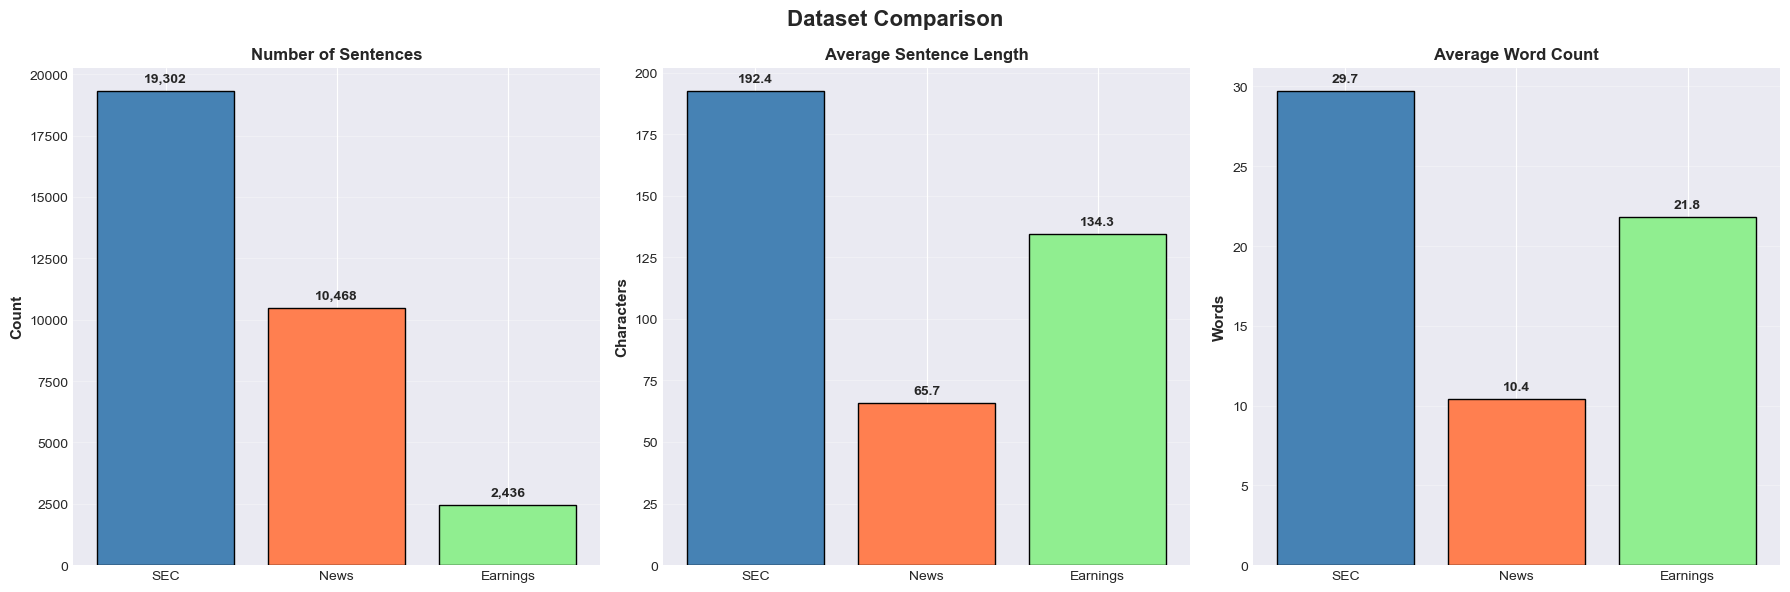

,Dataset,Sentences,Avg Length (chars),Avg Words
0,SEC,19302,192.4,29.7
1,News,10468,65.7,10.4
2,Earnings,2436,134.3,21.8


In [35]:
comparison_data = {
    'Dataset': ['SEC', 'News', 'Earnings'],
    'Sentences': [len(sec_sentences), len(news_sentences), len(earnings_sentences)],
    'Avg Length (chars)': [
        round(np.mean([len(s) for s in sec_sentences]), 1) if sec_sentences else 0,
        round(np.mean([len(s) for s in news_sentences]), 1) if news_sentences else 0,
        round(np.mean([len(s) for s in earnings_sentences]), 1) if earnings_sentences else 0
    ],
    'Avg Words': [
        round(np.mean([len(s.split()) for s in sec_sentences]), 1) if sec_sentences else 0,
        round(np.mean([len(s.split()) for s in news_sentences]), 1) if news_sentences else 0,
        round(np.mean([len(s.split()) for s in earnings_sentences]), 1) if earnings_sentences else 0
    ]
}

df_comparison = pd.DataFrame(comparison_data)


fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Dataset Comparison', fontsize=16, fontweight='bold')

colors = ['steelblue', 'coral', 'lightgreen']

axes[0].bar(df_comparison['Dataset'], df_comparison['Sentences'], color=colors, edgecolor='black')
axes[0].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0].set_title('Number of Sentences', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(df_comparison['Sentences']):
    axes[0].text(i, v + max(df_comparison['Sentences'])*0.02, f'{v:,}', 
                ha='center', fontweight='bold')

axes[1].bar(df_comparison['Dataset'], df_comparison['Avg Length (chars)'], color=colors, edgecolor='black')
axes[1].set_ylabel('Characters', fontsize=11, fontweight='bold')
axes[1].set_title('Average Sentence Length', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(df_comparison['Avg Length (chars)']):
    axes[1].text(i, v + max(df_comparison['Avg Length (chars)'])*0.02, f'{v:.1f}', 
                ha='center', fontweight='bold')

axes[2].bar(df_comparison['Dataset'], df_comparison['Avg Words'], color=colors, edgecolor='black')
axes[2].set_ylabel('Words', fontsize=11, fontweight='bold')
axes[2].set_title('Average Word Count', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(df_comparison['Avg Words']):
    axes[2].text(i, v + max(df_comparison['Avg Words'])*0.02, f'{v:.1f}', 
                ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(output_dir / 'dataset_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

display(df_comparison)

df_comparison.to_csv(output_dir / 'dataset_comparison.csv', index=False)

In [36]:
print("DATA QUALITY REPORT")


issues = {
    'too_short': [],
    'too_long': [],
    'duplicates': []
}


seen = set()

for sentence in all_sentences:
    if len(sentence) < 20:
        issues['too_short'].append(sentence)
    if len(sentence) > 500:
        issues['too_long'].append(sentence)
    if sentence in seen:
        issues['duplicates'].append(sentence)
    seen.add(sentence)

print(f"\nQuality Issues:")
print(f"  Too short (<20 chars): {len(issues['too_short'])}")
print(f"  Too long (>500 chars): {len(issues['too_long'])}")
print(f"  Duplicates: {len(issues['duplicates'])}")


total = len(all_sentences)
print(f"\nQuality Score:")
clean_sentences = total - len(issues['too_short']) - len(issues['too_long']) - len(issues['duplicates'])
print(f"  Clean sentences: {clean_sentences:,} ({clean_sentences/total*100:.1f}%)")



DATA QUALITY REPORT

Quality Issues:
  Too short (<20 chars): 1750
  Too long (>500 chars): 0
  Duplicates: 2400

Quality Score:
  Clean sentences: 28,056 (87.1%)
